# HW2: Solving Reaction-Diffusion Systems in the Persuit of Turing Patterns 

What is our goal? 

The goal of this project is to solve reaction-diffusion systems. We will start using the Brusselator model as an example. Many other examples of similar models, however, do exist. What is the Brusselator model? Give the chemical reaction model. Describe sdome of the physics. The Brusselator model is a model for two species that can be formulated in the following three ways: 
1. as a system of two coupled ordinary differential equations in time (t) as shown on the [wiki page](https://en.wikipedia.org/wiki/Brusselator) (reproduced below)
2. as a systems of two coupled partial differential equations in one dimension (x) and time (t) as shown [in Julia using BifurcationKit.jl](https://rveltz.github.io/BifurcationKit.jl/dev/tutorials/tutorials3/#d-Brusselator-(automatic)) (can we run this example?);
3. as a systems of two coupled partial differential equations in two dimensions (x and y) and time (t) as shown [in Python using py-pde](https://py-pde.readthedocs.io/en/latest/examples_gallery/pde_brusselator_expression.html) or  [in Julia using DifferentialEquations.jl](https://diffeq.sciml.ai/stable/tutorials/advanced_ode_example/); (test case from Hairer-II) or [in Julia using  MethodOfLines.jl](https://github.com/SciML/MethodOfLines.jl/blob/master/test/pde_systems/brusselator_eq.jl)
    
We expect to recover Turing patterns in the numerical solution as shown on the above wiki page. 

The goal of this project is to reproduce the above examples, understand the implementation, understand the numerical solution obtained and extend the Brusselator model to other examples (variation of the same homework assignment). 

Relevant component of ANM-2021 include the spatial discretization of the 1D and 2D diffusion equation, the linearization of the non-linear terms and the implicit methods for time integration.  

We expect to go through the following stages: 
1. spatial discretization of the linear diffusion operator using second order central finite differences on uniform meshes in 1D and 2D subject to various boundary conditions; 
2. spatial discretization of the non-linear reaction terms by collocation;
3. linearization by computating exact Jacobians (or otherwise);
4. implicit time integration using a variable time step set by imposing the accuracy of the time integration (settings for atol and rtol);

## Import Libraries

In [2]:
import numpy as np
print("Succesfully imported %s -- Version: %s"%(np.__name__,np.__version__))
import scipy
print("Succesfully imported %s -- Version: %s"%(scipy.__name__,scipy.__version__))
import matplotlib.pyplot as plt
print("Succesfully imported %s"%plt.__name__)
import pandas as pd
print("Succesfully imported %s -- Version: %s"%(pd.__name__,pd.__version__))
import sympy as sym 
print("Succesfully imported %s -- Version: %s"%(sym.__name__,sym.__version__))
from scipy import optimize
print("Succesfully imported %s"%optimize.__name__)
from scipy.optimize import fsolve
print("Succesfully imported %s"%fsolve.__name__)
from scipy.signal import find_peaks
print("Succesfully imported %s"%find_peaks.__name__)
from scipy.linalg import orth
print("Succesfully imported %s"%orth.__name__)
from scipy.integrate import odeint
print("Succesfully imported %s"%odeint.__name__)

Succesfully imported numpy -- Version: 1.20.1
Succesfully imported scipy -- Version: 1.6.2
Succesfully imported matplotlib.pyplot
Succesfully imported pandas -- Version: 1.2.4
Succesfully imported sympy -- Version: 1.8
Succesfully imported scipy.optimize
Succesfully imported fsolve
Succesfully imported find_peaks
Succesfully imported orth
Succesfully imported odeint


## Next Steps 

1. improve quality of the figures;

## Section 1/: Introduction and Model Description

Describe the Brusselator model as ODE (see wiki), a PDE in one spatial dimensions [see here](https://rveltz.github.io/BifurcationKit.jl/dev/tutorials/tutorials3/#d-Brusselator-(automatic)) (possiby better references do exist) and as PDE in two spatial dimensions (see above, and book by Hairer and Wannes Part 2).  

A demo of a oscillating chemical reaction is given here [An Oscalliation Chemical Reaction by the Royal Chemistry Society](https://www.youtube.com/watch?v=9TzYmmfcDW4).

## Section 2/: Brusselator model as ODE 

Work out the two examples on wiki using implicit time integration. Perform spectral analysis of the Jacobian. See wiki page for example of spectral analysis. Give physical interpretation. 

### Section 1.2/: Example of solving an ODE

The pendulum example that follows was taken from the [scipy.integrate.ode manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint). Explain software in more details. 

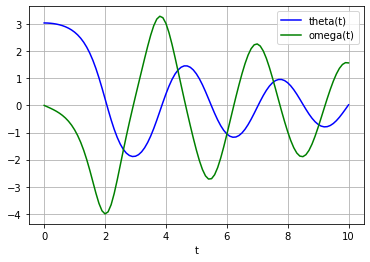

In [2]:
#..set rhs-function of ODE system 
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

#..set parameter values 
b=.25; c= 5.0;

#..set initial conditions 
y0 = [np.pi - 0.1, 0.0];

#..set time interval 
t = np.linspace(0, 10, 101);

#..solve ODE systemk 
sol = odeint(pend, y0, t, args=(b, c), full_output=1, printmessg=0);

#..plot solution obtained 
plt.plot(t, sol[0][:, 0], 'b', label='theta(t)')
plt.plot(t, sol[0][:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

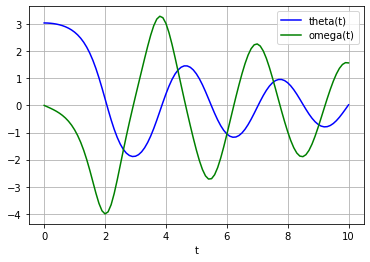

In [3]:
#..set rhs-function of ODE system for pendulum  
def righthandside_dt(y, t, b, c):
    theta, omega = y
    dy1 = omega
    dy2 = -b*omega - c*np.sin(theta)
    return [dy1, dy2]

#..set parameter values 
b=.25; c= 5.0;

#..set initial conditions 
y0 = [np.pi - 0.1, 0.0];

#..set time interval 
t = np.linspace(0, 10, 101);

#..solve ODE systemk 
sol = odeint(righthandside_dt, y0, t, args=(b, c), full_output=1, printmessg=0);

#..plot solution obtained 
plt.plot(t, sol[0][:, 0], 'b', label='theta(t)')
plt.plot(t, sol[0][:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

### Section 2.2/: Example of solving the Brusselator model using scipy.integrate.odeint()

The example that follows employs [scipy.integrate.odeint()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

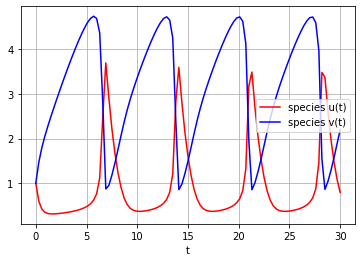

In [4]:
#..set rhs-function of ODE system 
def righthandside_dt(u, t, alpha, beta):
    X, Y = u
    du1 = alpha + X*X*Y - beta*X - X 
    du2 = beta*X - X*X*Y 
    return [du1, du2]

#..set parameter values 
alpha1=1; beta1=3;
alpha2=1; beta2=1.7;

#..set initial conditions 
u0 = [1.0, 1.0];

#..set time interval 
t = np.linspace(0, 30, 101);

#..solve ODE system
computed1 = odeint(righthandside_dt, u0, t, args=(alpha1, beta1), full_output=1, printmessg=0);
computed2 = odeint(righthandside_dt, u0, t, args=(alpha2, beta2), full_output=1, printmessg=0);

#..plot solution obtained 
plt.plot(t, computed1[0][:, 0], 'r', label='species u(t)')
plt.plot(t, computed1[0][:, 1], 'b', label='species v(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

### Section 3.2/: Brusselator again using now the scipy.integrate.solve_ivp() function 

The example that follows way modeled after [the scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). Observe: 
* different order of input arguments;
* different plotting functionality; what does dense_output = True do? 
* plotting can be further elaborated; 

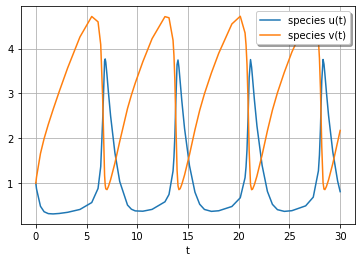

In [5]:
#..set rhs-function of ODE system 
def righthandside_dt(t, u, alpha, beta):
    X, Y = u
    du1 = alpha + X*X*Y - beta*X - X 
    du2 = beta*X - X*X*Y 
    return [du1, du2]

#..set parameter values 
alpha1=1; beta1=3;
alpha2=1; beta2=1.7;

#..set initial conditions 
u0 = [1.0, 1.0];

#..solve ODE system
computed1 = scipy.integrate.solve_ivp(righthandside_dt, t_span=[0,30], y0=u0, args=(alpha1, beta1), dense_output=True);
computed2 = scipy.integrate.solve_ivp(righthandside_dt, t_span=[0,30], y0=u0, args=(alpha2, beta2), dense_output=True);

#..set time sampling for post-processing 
tpost = np.linspace(0, 30, 101);

#..plot solution obtained 
z = computed1.y
plt.plot(computed1.t, z.T)
plt.legend(['species u(t)', 'species v(t)'], shadow=True)
plt.xlabel('t')
plt.grid()
plt.show()

## Section 3:/ Fisher Equation in x and t
We reproduce the reference solution for Fisher equation [Fisher Equation](https://people.maths.ox.ac.uk/trefethen/pdectb/fisher2.pdf)

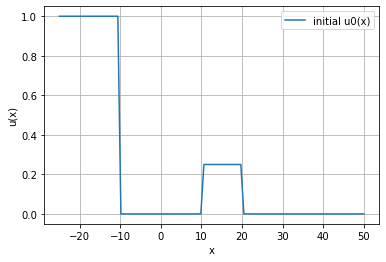

In [11]:
#..set the initial solution 
nsamples = 100 
xvec = np.linspace(-25,50,nsamples)
u0 = (xvec<=-10)+0.25*((10<=xvec)*(xvec<=20))

#..plot the computed solution 
plt.plot(xvec,u0,label='initial u0(x)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend(loc='best')
plt.grid()
plt.show()

(101, 41)


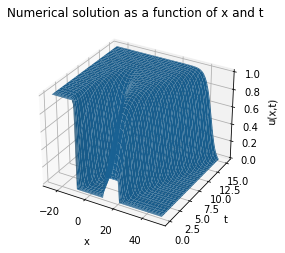

In [12]:
def poisson_1d(N):
    h = 75/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=0; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=0; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    dudt = -np.dot(A,u) + u*(1-u)
    return dudt

N = 100

A = poisson_1d(N)

#..set initial guess   
xvec = np.linspace(-25,50,N+1)
u0 = (xvec<=-10)+0.25*((10<=xvec)*(xvec<=20))

#..perform time integration  
computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,fvec),t_span=[0,15],y0=u0)

#..prepare variables for plotting 
t = computed.t
XX, TT = np.meshgrid(xvec,t[1:])

#..post-processing 
fig = plt.figure()
axes = fig.gca(projection='3d')
z = computed.y[:,1:]
print(np.shape(z))
axes.plot_surface(XX,TT,z.T)
axes.set_xlabel('x')
axes.set_ylabel('t')
axes.set_zlabel('u(x,t)')
axes.set_title('Numerical solution as a function of x and t')
plt.show()

## Section 4/: Brusselator model as PDE in 1D 

A model formulation is given in [Section 4.1 of Lust-1997](https://epubs.siam.org/doi/epdf/10.1137/S1064827594277673). Values of $L$ are given in Figure 4.1 of the same reference. Initial values (steady state branch?) for $X$ and $Y$ are left unspecified. Should we use $X(x,0) = A$ and $Y(x,0) = B/A$?. 

Model is various intermediate steps. 

### Section 1.4/: Diffusion Matrix as a Script  

In [6]:
N = 4; h=1/N; h2=h*h; xvec = np.linspace(0,1,N+1);
e = np.ones(N+1); 
A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
A = (1/h2)*A; 
A[0][0]=1; A[0][1]=0;     # handling left-most boundary condition 
A[-1][-1]=2/h2; A[-1][-2]=-2/h2; # handling right-most Neumann boundary condition 
#A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirichlet boundary condition
print(A); #print(xvec)

[[  1.   0.   0.   0.   0.]
 [-16.  32. -16.   0.   0.]
 [  0. -16.  32. -16.   0.]
 [  0.   0. -16.  32. -16.]
 [  0.   0.   0. -32.  32.]]


### Section 2.4/: Diffusion matrix as a Function (needs more work on boundary conditions and making sparse) 

Seperate cell to test the construction of 1D diffusion matrix. Will be absorbed in a seperate notebook later.

In [7]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

N = 5 

A = poisson_1d(N)
print(A)

[[  1.   0.   0.   0.   0.   0.]
 [-25.  50. -25.   0.   0.   0.]
 [  0. -25.  50. -25.   0.   0.]
 [  0.   0. -25.  50. -25.   0.]
 [  0.   0.   0. -25.  50. -25.]
 [  0.   0.   0.   0.   0.   1.]]


### Section 3.4/: Right-Hand Function for ODE

Seperate cell to test the application of the right-hand side function. 

In [8]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    dudt = 0.1*np.dot(A,u)  + u**2
    return dudt

N = 4

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
k = 3 
u0 = np.sin(k*np.pi*x)

computed = righthandside_dt(t,u0,A)

display(computed)

array([ 0.0000000e+00,  4.3627417e+00, -4.4627417e+00,  4.3627417e+00,
        3.6739404e-17])

### Section 4.4/: Perform Time Integration without Post-Processing 

In [9]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    dudt = 0.1*np.dot(A,u)  # + 1*u**2
    return dudt

N = 40

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
u0 = np.sin(k*np.pi*x)

computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,),t_span=[0,0.1],y0=u0, dense_output=True)

t = computed1.t

print(np.shape(computed.y[:,5:]))
print(computed)
print(computed.y)

(41, 0)
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7fbba802b2d0>
   status: 0
  success: True
        t: array([0.        , 0.04205079, 0.1       ])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.33445364e-01,  3.38575051e-01,  5.65217853e-01],
       [ 4.53990500e-01,  6.58440391e-01,  1.09899665e+00],
       [ 6.49448048e-01,  9.41920209e-01,  1.57240249e+00],
       [ 8.09016994e-01,  1.17334937e+00,  1.95849323e+00],
       [ 9.23879533e-01,  1.33993905e+00,  2.23675926e+00],
       [ 9.87688341e-01,  1.43248349e+00,  2.39109298e+00],
       [ 9.96917334e-01,  1.44586867e+00,  2.41356307e+00],
       [ 9.51056516e-01,  1.37935491e+00,  2.30236827e+00],
       [ 8.52640164e-01,  1.23661778e+00,  2.06438874e+00],
       [ 7.07106781e-01,  1.02554495e+00,  1.71159371e+00],
       [ 5.22498565e-

### Section 4.4/: Perform Time Integration and Post-Processing

(41, 921)


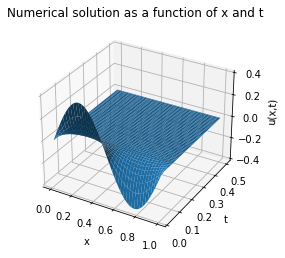

In [10]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    dudt = -np.dot(A,u)  # + u**2
    return dudt

N = 40

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
k = 2
u0 = np.sin(k*np.pi*x)

#..perform time integration  
computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,),t_span=[0,0.5],y0=u0)

#..prepare variables for plotting 
t = computed.t
XX, TT = np.meshgrid(x,t[1:])

#..post-processing 
fig = plt.figure()
axes = fig.gca(projection='3d')
z = computed.y[:,1:]
print(np.shape(z))
axes.plot_surface(XX,TT,z.T)
axes.set_xlabel('x')
axes.set_ylabel('t')
axes.set_zlabel('u(x,t)')
axes.set_title('Numerical solution as a function of x and t')
plt.show()

### Section 4.4/: Perform Time Integration and Post-Processing on block form as initial guess (first attempt to work with Fisher equation)

(41, 26)


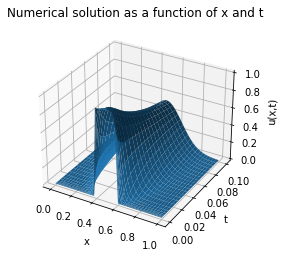

In [18]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    dudt = -0.1*np.dot(A,u)+u*(u-.4)
    return dudt

N = 40

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
k = 2
u0 = (x>=0.4)*(x<=0.6)

#..perform time integration  
computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,),t_span=[0,0.1],y0=u0)

#..prepare variables for plotting 
t = computed.t
XX, TT = np.meshgrid(x,t[1:])

#..post-processing 
fig = plt.figure()
axes = fig.gca(projection='3d')
z = computed.y[:,1:]
print(np.shape(z))
axes.plot_surface(XX,TT,z.T)
axes.set_xlabel('x')
axes.set_ylabel('t')
axes.set_zlabel('u(x,t)')
axes.set_title('Numerical solution as a function of x and t')
plt.show()

### Section 5.4/: Seperate Test on Vector Concatenation and Slicing

In [13]:
#..put two vectors together 
uu0 = np.array([1., 2.])
vv0 = np.array([3., 4.])
u0 = np.concatenate([uu0,vv0]) 
print(u0)

#..take vectors apart gain 
n = np.size(u0)
print(n//2)
uuu0 = u0[:n//2]; vvv0 = u0[n//2:]
print(uuu0)
print(vvv0)

[1. 2. 3. 4.]
2
[1. 2.]
[3. 4.]


### Section 6.4/: Seperate Test on Matrix Slicing

In [14]:
A = np.array([[1., 2., 3., 4.],[10., 20., 30., 40.]])
print(A[:,2:])

[[ 3.  4.]
 [30. 40.]]


### Section 7.4/: Right-Hand Function for ODE for Two Species 

In [15]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    n = np.size(u)
    uu = u[:n//2]; vv = u[n//2:]
    duudt = - 0.1*np.dot(A,uu)  + uu**2
    dvvdt = - 0.1*np.dot(A,vv)  + vv**2
    dudt = np.concatenate([uu,vv])
    return dudt

N = 4

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
k = 3; uu0 = np.sin(k*np.pi*x)
k = 5; vv0 = np.sin(k*np.pi*x)
u0 = np.concatenate([uu0,vv0])

computed = righthandside_dt(t,u0,A)

display(computed)

array([ 0.00000000e+00,  7.07106781e-01, -1.00000000e+00,  7.07106781e-01,
        3.67394040e-16,  0.00000000e+00, -7.07106781e-01,  1.00000000e+00,
       -7.07106781e-01,  6.12323400e-16])

### Section 8.4/: Perform Time Integration without Post-Processing for ODE for Two Species 

In [16]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    n = np.size(u)
    uu = u[:n//2]; vv = u[n//2:]
    duudt = 0.1*np.dot(A,uu)  + uu**2
    dvvdt = 0.1*np.dot(A,vv)  + vv**2
    dudt = np.concatenate([uu,vv])
    return dudt

N = 4

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
k = 3; uu0 = np.sin(k*np.pi*x)
k = 5; vv0 = np.sin(k*np.pi*x)
u0 = np.concatenate([uu0,vv0])

computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,),t_span=[0,0.5],y0=u0, dense_output=True)

print(computed)
print(computed.sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7fa3b8acf3d0>
   status: 0
  success: True
        t: array([0.        , 0.10526782, 0.5       ])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.07106781e-01,  7.85601379e-01,  1.16582257e+00],
       [-1.00000000e+00, -1.11100812e+00, -1.64872209e+00],
       [ 7.07106781e-01,  7.85601379e-01,  1.16582257e+00],
       [ 3.67394040e-16,  4.08177763e-16,  6.05730670e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.07106781e-01, -7.85601379e-01, -1.16582257e+00],
       [ 1.00000000e+00,  1.11100812e+00,  1.64872209e+00],
       [-7.07106781e-01, -7.85601379e-01, -1.16582257e+00],
       [ 6.12323400e-16,  6.80296272e-16,  1.00955112e-15]])
 y_events: None


### Section 7.4/: Perform Time Integration with Post-Processing for ODE for Two Species 

(42, 1000)


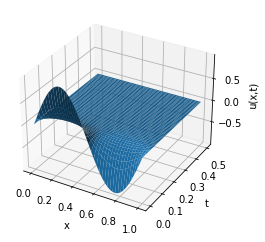

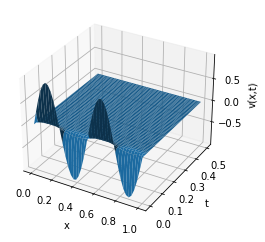

In [17]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def righthandside_dt(t,u,A):
    n = np.size(u)
    uu = u[:n//2]; vv = u[n//2:];     
    duudt = -np.dot(A,uu)  # + u**2
    dvvdt = -np.dot(A,vv)  # + u**2
    dudt = np.concatenate([duudt,dvvdt])
    return dudt

N = 41; Np1 = N+1 

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
k = 2; uu0 = np.sin(k*np.pi*x)
k = 4; vv0 = np.sin(k*np.pi*x)
u0 = np.concatenate([uu0,vv0])

#..perform time integration  
computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,),t_span=[0,0.5],y0=u0)

#..prepare variables for plotting 
t = computed.t
XX, TT = np.meshgrid(x,t)
zu = computed.y[:Np1,:]
zv = computed.y[Np1:,:]
print(np.shape(zu))

#..post-processing 
fig = plt.figure()
ax1 = fig.gca(projection='3d')
ax1.plot_surface(XX,TT,zu.T)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('u(x,t)')
plt.show() 
fig = plt.figure()
ax2 = fig.gca(projection='3d')
ax2.plot_surface(XX,TT,zv.T)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('v(x,t)')
plt.show()

### Section 8.4/: Perform Time Integration with Post-Processing for ODE for Two Species 

(42, 5377)


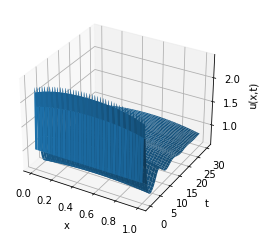

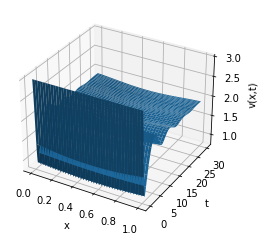

In [18]:
def poisson_1d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A = (1/h2)*A; 
    A[0][0]=1; A[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A[-1][-1]=1; A[-1][-2]=0; # handling right-most Dirchlet boundary condition 
    return A

def ode_dt(u, t, alpha, beta):
    X, Y = u
    du1 = alpha + X*X*Y - beta*X - X 
    du2 = beta*X - X*X*Y 
    return [du1, du2]


def righthandside_dt(t,u,A):
    alpha = 1; beta = 3; beta = 1.7; 
    D1 = 0.008; D2 = 0.004; l = 0.3; 
    n = np.size(u)
    uu = u[:n//2]; vv = u[n//2:];     
    duudt = -(D1/l**2)*np.dot(A,uu) + alpha + uu**2*vv - beta*uu - uu 
    dvvdt = -(D2/l**2)*np.dot(A,vv) + beta*uu - uu**2*vv 
    dudt = np.concatenate([duudt,dvvdt])
    return dudt

N = 41; Np1 = N+1 

A = poisson_1d(N)

# define right-hand side vector 
x = np.linspace(0,1,N+1)
alpha = 1; beta = 3
k = 2; uu0 = alpha*np.ones(np.size(x)); # np.sin(k*np.pi*x)
k = 4; vv0 = (beta/alpha)*np.ones(np.size(x)); # np.sin(k*np.pi*x)
u0 = np.concatenate([uu0,vv0])

#..perform time integration  
computed = scipy.integrate.solve_ivp(righthandside_dt,args=(A,),t_span=[0,30],y0=u0)

#..prepare variables for plotting 
t = computed.t
XX, TT = np.meshgrid(x,t)
zu = computed.y[:Np1,:]
zv = computed.y[Np1:,:]
print(np.shape(zu))

#..post-processing 
fig = plt.figure()
ax1 = fig.gca(projection='3d')
ax1.plot_surface(XX,TT,zu.T)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('u(x,t)')
plt.show() 
fig = plt.figure()
ax2 = fig.gca(projection='3d')
ax2.plot_surface(XX,TT,zv.T)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('v(x,t)')
plt.show()

## Section 5/: Brusselator model as PDE in 2D 

Add non-linear terms to two copies of the Poisson-2D matrix (see ANM-2021 Python introduction), perform implicit time integration. 

### Section 1.5/: Create 2D Poisson matrix as Function 

In [22]:
# need to identify boundary nodes 
# need to set submatrix of A equal to the identity matrix 
def poisson_2d(N):
    h = 1/N; h2=h*h; 
    e = np.ones(N+1); 
    A1 = np.diag(-e[:-1],k=1)+np.diag(2*e)+np.diag(-e[:-1],k=-1); # tridiagonal matrix 
    A1 = (1/h2)*A1; 
    A1[0][0]=1; A1[0][1]=0;     # handling left-most Dirchlet boundary condition 
    A1[-1][-1]=1; A1[-1][-2]=0; # handling right-most Dirchlet boundary condition
    B1 = np.identity(N+1);
    A = np.kron(A1,B1) + np.kron(B1,A1)
    return A

N = 2

A = poisson_2d(N)
print(A)

[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-4.  9. -4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [-4.  0.  0.  9.  0.  0. -4.  0.  0.]
 [-0. -4. -0. -4. 16. -4. -0. -4. -0.]
 [ 0.  0. -4.  0.  0.  9.  0.  0. -4.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -4.  9. -4.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.]]


## Section 6/: Other Models 

Repeat above for Fisher equation, Kolmogorov-Petrovsky-Piskunov equation, Oregonator model, Schnakenberg model, Gray-Scott model and FitzHugh–Nagumo model; 

## Section 7/: Reference Models in Not Python 
see [notebook](not-python-HW2-pde-reaction-diffusion.ipynb)

## References 

To be extended. 

1. [Reaction-Diffusion Systems and Gray-Scott Model](https://en.wikipedia.org/wiki/Reaction–diffusion_system)

2. [Fisher and KPP Equation](https://en.wikipedia.org/wiki/Fisher%27s_equation). Document analytical solutions for the Fisher equation. Source term $F(u) = u(1-u)$. Very similar to growth model in ANM-2021. Explain solutions. Solve Fisher equation using finite differences in space and implicit time-stepping with variable time step;

3. [Brusselator Model](https://en.wikipedia.org/wiki/Brusselator)

4. [Oregonator Model](https://en.wikipedia.org/wiki/Oregonator): model for auto-catalysis, and thus interesting to explore; 

5. [Implementation of Brusselator Model Ready to Roll](https://diffeq.sciml.ai/stable/tutorials/advanced_ode_example/) See Hairer-2 for the definition of the test case;

6. [Book by Grindrod](http://www.grindrodbook.com/)

7. Guiu-Souto, Jacobo, et al. "Manipulation of diffusion coefficients via periodic vertical forcing controls the mechanism of Turing pattern formation." Physical Review E 82.6 (2010): 066209 [https://journals.aps.org/pre/pdf/10.1103/PhysRevE.82.066209?casa_token=StWd8LAlg18AAAAA%3AVcXU45U2oSxFH8C4juSzSK2PsMNAEcZ3BvqrpdqF9NUXjJPL5H5NuTTGZ0MZsZrsAoxIAu21NjX0]

8. Guiu-Souto, Jacobo, Jorge Carballido-Landeira, and Alberto P. Munuzuri. "Characterizing topological transitions in a Turing-pattern-forming reaction-diffusion system." Physical Review E 85.5 (2012): 056205. [https://journals.aps.org/pre/abstract/10.1103/PhysRevE.85.056205]